# Large ML Models Market Analysis Agent

This notebook demonstrates the automated analysis of the most popular large ML models (such as LLMs) and their competitive aspects.

The implementation is kept simple, leaving room for several potential improvements, such as:
- Using reasoning steps (with LLM) to decide which information to gather rather than using a fixed workflow
- Increasing the number of information providers
- Engineering improvements (such as converting the notebook to a script, using requirements.txt for dependencies, Python type hints, etc)
- etc

## Setup

In [262]:
# Get `TAVILY_API_KEY` & `OPENAI_API_KEY` from .env file.
%reload_ext dotenv
%dotenv

In [260]:
%pip install huggingface_hub tavily-python openai arxiv beautifulsoup4 Jinja2 markdown graphviz

Note: you may need to restart the kernel to use updated packages.


In [210]:
from huggingface_hub import HfApi
from tavily import TavilyClient
from openai import OpenAI
import arxiv
from bs4 import BeautifulSoup
import markdown
from IPython.display import Markdown, Image, display
from inspect import signature
import pandas as pd
import re
import os

In [175]:
hf_api = HfApi()
tavily_client = TavilyClient(os.getenv("TAVILY_API_KEY"))
arxiv_client = arxiv.Client()
llm_client = OpenAI(api_key = os.getenv("OPENAI_API_KEY"))

## Agent overview

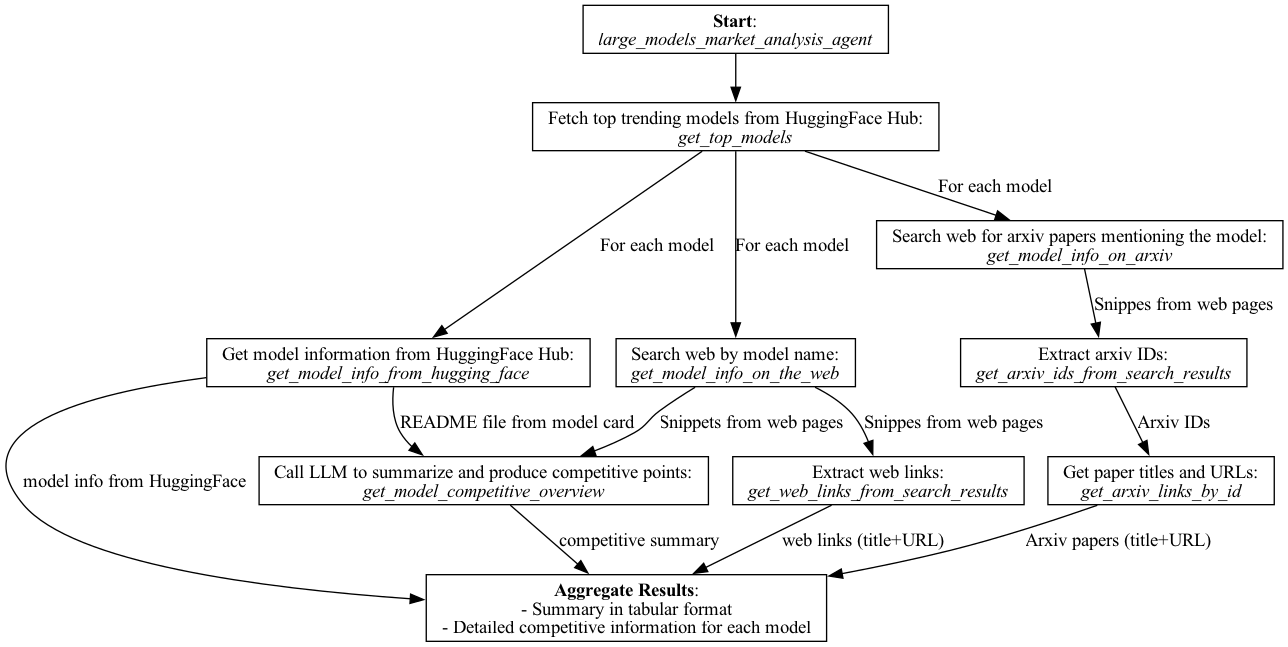

In [264]:
from graphviz import Digraph

# Create a directed graph
dot = Digraph(comment='Large Models Market Analysis Agent', format='png')

# Set default shape for all nodes to 'rectangle'
dot.attr('node', shape='rect')

# Define nodes
dot.node('A', '< <b>Start</b>: <br/> <i>large_models_market_analysis_agent</i> >')
dot.node('B', '< Fetch top trending models from HuggingFace Hub: <br/> <i>get_top_models</i> >')
dot.node('C', '< Get model information from HuggingFace Hub: <br/> <i>get_model_info_from_hugging_face</i> >')
dot.node('D', '< Search web by model name: <br/> <i>get_model_info_on_the_web</i> >')
dot.node('E', '< Extract web links: <br/> <i>get_web_links_from_search_results</i> >')
dot.node('F', '< Search web for arxiv papers mentioning the model: <br/> <i>get_model_info_on_arxiv</i> >')
dot.node('G', '< Extract arxiv IDs: <br/> <i>get_arxiv_ids_from_search_results</i> >')
dot.node('H', '< Get paper titles and URLs: <br/> <i>get_arxiv_links_by_id</i> >')
dot.node('I', '< Call LLM to summarize and produce competitive points: <br/> <i>get_model_competitive_overview</i> >')
dot.node('J', '< <b>Aggregate Results</b>: <br/> - Summary in tabular format <br/> - Detailed competitive information for each model >')

# Define edges (workflow)
dot.edge('A', 'B')
dot.edge('B', 'C', label='For each model')
dot.edge('B', 'D', label='For each model')
dot.edge('D', 'E', label='Snippes from web pages')
dot.edge('B', 'F', label='For each model')
dot.edge('F', 'G', label='Snippes from web pages')
dot.edge('G', 'H', label='Arxiv IDs')
dot.edge('C', 'I', label='README file from model card')
dot.edge('D', 'I', label='Snippets from web pages')

dot.edge('C', 'J', label='model info from HuggingFace')
dot.edge('E', 'J', label='web links (title+URL)')
dot.edge('H', 'J', label='Arxiv papers (title+URL)')
dot.edge('I', 'J', label='competitive summary')

# Render the diagram to a byte stream and display it
png_bytes = dot.pipe(format='png')
display(Image(png_bytes))

## Tool logging

In [176]:
def log_tool_request(request):
    print(f"< REQ {request}")

def log_tool_response(response):
    print(f"> RSP {response}")

In [177]:
def log_tool_invocation(description=None):
    def decorator(func):
        def wrapper(*args, **kwargs):
            # Extract argument names and values
            func_sig = signature(func)
            bound_args = func_sig.bind(*args, **kwargs)
            bound_args.apply_defaults()
            args_str = ", ".join(f"{key}={value}" for key, value in bound_args.arguments.items())
            
            log_tool_request(f"{description} {args_str}")
            
            result = func(*args, **kwargs)
            log_tool_response(result)
            return result
        return wrapper
    return decorator

## Tool definitions

In [178]:
@log_tool_invocation("Retrieving top large models from HuggingFace Hub")
def get_top_models(n = 10):
    models = hf_api.list_models(sort="trending_score", limit=n)
    return [model.modelId for model in models]

In [179]:
def format_datetime_readable(dt):
    return dt.strftime('%d %B %Y at %H:%M:%S %Z')

In [180]:
def read_file(file_path):
    with open(file_path, 'r') as file:
        return file.read()

In [181]:
@log_tool_invocation("Retrieving model information from HuggingFace Hub")
def get_model_info_from_hugging_face(model_id):
    model_info = hf_api.model_info(repo_id=model_id, expand=["createdAt", "downloads", "likes", "trendingScore"])

    description = read_file(hf_api.hf_hub_download(model_id, 'README.md'))

    model_info = {
        "model_id": model_id,
        "created_at": format_datetime_readable(model_info.created_at),
        "downloads": model_info.downloads,
        "likes": model_info.likes,
        "trending_score": model_info.trending_score,
        "description": description
        }
    return model_info

In [182]:
@log_tool_invocation("Retrieving model information on the web using Tavily")
def get_model_info_on_the_web(model_id):
    response = tavily_client.search(model_id)
    return response['results']

In [183]:
@log_tool_invocation("Retrieving model information on arxiv documents using Tavily")
def get_model_info_on_arxiv(model_id):
    response = tavily_client.search(model_id, include_domains=["arxiv.org"], max_results=10)
    return response['results']

In [184]:
def get_arxiv_ids_from_search_results(search_results):
    arxiv_ids = set()
    for result in search_results:
        url = result['url']

        # Extract the ArXiv ID from the URL
        match = re.search(r'arxiv\.org/(abs|pdf|html)/([\d.]+)(v\d+)?', url)
        if match:
            arxiv_id = match.group(2)
            arxiv_ids.add(arxiv_id)
    return arxiv_ids

In [185]:
@log_tool_invocation("Retrieving paper information using Arxiv API")
def get_arxiv_links_by_id(arxiv_id):
    search = arxiv.Search(id_list=[arxiv_id])
    for paper in arxiv_client.results(search):
        return f"[{paper.title}]({paper})" # assume there is only one paper
    return None

In [186]:
@log_tool_invocation("Calling OpenAI gpt-4o-mini model")
def call_llm(system_prompt, message):
    completion = llm_client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": [{"type": "text", "text": system_prompt}]},
            {"role": "user", "content": [{"type": "text", "text": message}]}
        ])
    return completion.choices[0].message.content

In [194]:
def remove_markdown_formatting(markdown_content):
    html_content = markdown.markdown(markdown_content)
    
    # Use BeautifulSoup to remove HTML tags and get plain text
    soup = BeautifulSoup(html_content, 'html.parser')
    text = soup.get_text(separator='\n', strip=True)
    return text[:50_000] # trim so that LLM calls don't fail

In [188]:
# SYSTEM_PROMPT = """You are a helpful assistant that performs short and concise summarization of the large machine learning models.
# Below you would see the contents of the README FILE (MODEL CARD), as well as the WEB SEARCH RESULTS for this model.
# Use both of these sources to construct the summary, but prioritize web search results.
# Use bullets to summarize the model competitive characteristics, and pay special attention to mention those characteristics which best differenciate this model from any others."""

# SYSTEM_PROMPT = """Summarize using bullets."""

SYSTEM_PROMPT = """Given the information below, summarize the large machine learning model competitive characteristics (how it differentiates from any other model) using no more than 10 single-level bullets. Only output these bullets, not any extra text.

Example of the required output:
* Characteristic 1
* Characteristic 2
* Characteristic 3
..."""

def get_model_competitive_overview(model_description, model_web_info):
    model_info = f"# WEB SEARCH RESULTS\n{model_web_info}\n\n# README FILE (MODEL CARD)\n{remove_markdown_formatting(model_description)}"
    return call_llm(SYSTEM_PROMPT, model_info)

In [189]:
def get_web_links_from_search_results(search_results):
    return set([f"[{result['title']}]({result['url']})" for result in search_results])

## Combining the information from individual tools

In [190]:
def large_models_market_analysis_agent():
    top_models = get_top_models()

    models_info = {}
    for model_id in top_models:
        models_info[model_id] = get_model_info_from_hugging_face(model_id)

        models_info[model_id]['web_info'] = get_model_info_on_the_web(model_id)
        models_info[model_id]['web_links'] = get_web_links_from_search_results(models_info[model_id]['web_info'])

        arxiv_search_results = get_model_info_on_arxiv(model_id)
        arxiv_ids = get_arxiv_ids_from_search_results(arxiv_search_results)
        models_info[model_id]['papers'] = [get_arxiv_links_by_id(arxiv_id) for arxiv_id in arxiv_ids]

        models_info[model_id]['competitive_overview'] = get_model_competitive_overview(models_info[model_id]['description'], models_info[model_id]['web_info'])

    return models_info

## Results presentation

In [191]:
def get_comparison_table(models_info):
    required_columns = {
        "created_at": "Created At",
        "downloads": "Total Downloads",
        "likes": "Total Likes",
        "trending_score": "Trending Score",
    }
    
    # Extract only the required columns
    filtered_data = [
        {**{"Model Name": model}, **{required_columns[key]: details.get(key) for key in required_columns}}
        for model, details in models_info.items()
    ]
    
    return pd.DataFrame(filtered_data)

In [192]:
def get_models_overview(models_info):
    md_content = ""

    for model_id, details in models_info.items():
        md_content += f"\n# {model_id}\n\n"
        md_content += details['competitive_overview']
        md_content += f"\n\nMentioned in the following web pages:\n"
        for web_link in details['web_links']:
            md_content += f"* {web_link}\n"
        md_content += f"\nMentioned in the following papers:\n"
        for paper in details['papers']:
            md_content += f"* {paper}\n"
    return md_content

## Running the market analysis

In [195]:
models_info = large_models_market_analysis_agent()

< REQ Retrieving top large models from HuggingFace Hub n=10
> RSP ['deepseek-ai/DeepSeek-V3', 'PowerInfer/SmallThinker-3B-Preview', 'deepseek-ai/DeepSeek-V3-Base', 'black-forest-labs/FLUX.1-dev', 'hexgrad/Kokoro-82M', 'meta-llama/Llama-3.3-70B-Instruct', 'StephanST/WALDO30', 'nomic-ai/modernbert-embed-base', 'cognitivecomputations/Dolphin3.0-Llama3.1-8B', 'stabilityai/stable-diffusion-3.5-large']
< REQ Retrieving model information from HuggingFace Hub model_id=deepseek-ai/DeepSeek-V3
> RSP {'model_id': 'deepseek-ai/DeepSeek-V3', 'created_at': '25 December 2024 at 12:52:23 UTC', 'downloads': 74084, 'likes': 1412, 'trending_score': 612, 'description': '<!-- markdownlint-disable first-line-h1 -->\n<!-- markdownlint-disable html -->\n<!-- markdownlint-disable no-duplicate-header -->\n\n<div align="center">\n  <img src="https://github.com/deepseek-ai/DeepSeek-V2/blob/main/figures/logo.svg?raw=true" width="60%" alt="DeepSeek-V3" />\n</div>\n<hr>\n<div align="center" style="line-height: 1;">\

In [196]:
get_comparison_table(models_info).style.hide(axis='index')

Model Name,Created At,Total Downloads,Total Likes,Trending Score
deepseek-ai/DeepSeek-V3,25 December 2024 at 12:52:23 UTC,74084,1412,612
PowerInfer/SmallThinker-3B-Preview,12 December 2024 at 11:56:09 UTC,6996,288,217
deepseek-ai/DeepSeek-V3-Base,25 December 2024 at 12:52:06 UTC,8663,1180,188
black-forest-labs/FLUX.1-dev,31 July 2024 at 21:13:44 UTC,1166389,7800,182
hexgrad/Kokoro-82M,26 December 2024 at 00:20:08 UTC,1479,269,168
meta-llama/Llama-3.3-70B-Instruct,26 November 2024 at 16:08:47 UTC,416929,1517,128
StephanST/WALDO30,02 October 2024 at 14:20:40 UTC,0,163,102
nomic-ai/modernbert-embed-base,29 December 2024 at 23:51:30 UTC,4837,135,89
cognitivecomputations/Dolphin3.0-Llama3.1-8B,29 December 2024 at 18:37:00 UTC,242,82,82
stabilityai/stable-diffusion-3.5-large,22 October 2024 at 07:29:57 UTC,127483,1807,66


In [197]:
display(Markdown(get_models_overview(models_info)))


# deepseek-ai/DeepSeek-V3

* Outperforms leading open-source models and rivals closed models.
* Utilizes a unique Mixture-of-Experts architecture with 671B parameters.
* Features an economical training process requiring only 2.788M GPU hours.
* Implements innovative Multi-head Latent Attention for efficient inference.
* Introduces an auxiliary-loss-free load balancing strategy.
* Achieves remarkable performance across extensive benchmarks, especially in math and code tasks.
* Supports a context window length of up to 128K tokens.
* Open-source with permissive licensing for commercial use.
* Allows for easy local deployment using various optimized frameworks.
* Pioneers advancements in FP8 mixed precision training for large-scale models.

Mentioned in the following web pages:
* [DeepSeek-V3 Technical Report - arXiv.org](https://arxiv.org/pdf/2412.19437)
* [DeepSeek-V3, ultra-large open-source AI, outperforms ... - VentureBeat](https://venturebeat.com/ai/deepseek-v3-ultra-large-open-source-ai-outperforms-llama-and-qwen-on-launch/)
* [DeepSeek V3: New Open AI Model Surpasses Rivals and ... - WinBuzzer](https://winbuzzer.com/2024/12/27/deepseek-v3-new-open-ai-model-surpasses-rivals-and-challenges-gpt-4o-xcxwbn/)
* [Introducing DeepSeek-V3 | DeepSeek API Docs](https://api-docs.deepseek.com/news/news1226)
* [DeepSeek's new AI model appears to be one of the best 'open ...](https://techcrunch.com/2024/12/26/deepseeks-new-ai-model-appears-to-be-one-of-the-best-open-challengers-yet/)

Mentioned in the following papers:
* [DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models](http://arxiv.org/abs/2402.03300v3)
* [DeepSeek-V3 Technical Report](http://arxiv.org/abs/2412.19437v1)
* [DeepSeek LLM: Scaling Open-Source Language Models with Longtermism](http://arxiv.org/abs/2401.02954v1)

# PowerInfer/SmallThinker-3B-Preview

* Compact size ideal for resource-constrained devices
* High-quality inference with minimal computational overhead
* Designed for edge deployment and mobile applications
* Accelerated performance compared to larger models (up to 70% speedup)
* Fine-tuned on specialized datasets for improved accuracy
* Strong benchmark performance surpassing some larger models
* Versatile applications as a draft model for larger models
* Trained with advanced techniques like Supervised Fine-Tuning (SFT)
* Accessible on platforms like Hugging Face for easy integration
* Holds potential for further enhancement with more extensive datasets and training

Mentioned in the following web pages:
* [SmallThinker 3B: A Small Thinking Model Revolutionizing AI Efficiency](https://pub.towardsai.net/smallthinker-3b-a-small-thinking-model-revolutionizing-ai-efficiency-f528cf7d6906)
* [bartowski/SmallThinker-3B-Preview-GGUF - Hugging Face](https://huggingface.co/bartowski/SmallThinker-3B-Preview-GGUF)
* [PowerInfer/SmallThinker-3B-Preview at main - Hugging Face](https://huggingface.co/PowerInfer/SmallThinker-3B-Preview/tree/main)
* [Testing SmallThinker 3B Preview by PowerInfer - YouTube](https://www.youtube.com/watch?v=OVNnXQp_wNU)
* [SmallThinker 3B Preview By PowerInfer: Benchmarks, Features and ...](https://llm.extractum.io/model/PowerInfer/SmallThinker-3B-Preview,6YvWQRdkYbb2o0HqvU7LTJ)

Mentioned in the following papers:
* [PowerInfer-2: Fast Large Language Model Inference on a Smartphone](http://arxiv.org/abs/2406.06282v3)
* [PowerInfer: Fast Large Language Model Serving with a Consumer-grade GPU](http://arxiv.org/abs/2312.12456v2)

# deepseek-ai/DeepSeek-V3-Base

* Outperforms existing leading open-source models in benchmarks.
* Strong performance on specialized tasks like math and code generation.
* Efficient training requiring only 2.788M H800 GPU hours.
* Utilizes a Mixture-of-Experts (MoE) architecture with 671B total parameters.
* Features innovative Multi-Token Prediction (MTP) training objective.
* Pioneers an auxiliary-loss-free load balancing strategy.
* Demonstrates stability throughout the training process without significant loss spikes.
* Offers competitive performance against closed-source models from major companies.
* Supports both FP8 and BF16 inference modes for versatile deployment.
* Capable of processing up to 128K context length for extensive input handling.

Mentioned in the following web pages:
* [DeepSeek-V3, ultra-large open-source AI, outperforms ... - VentureBeat](https://venturebeat.com/ai/deepseek-v3-ultra-large-open-source-ai-outperforms-llama-and-qwen-on-launch/)
* [DeepSeek-V3 Technical Report - arXiv.org](https://arxiv.org/pdf/2412.19437)
* [Paper page - DeepSeek-V3 Technical Report - Hugging Face](https://huggingface.co/papers/2412.19437)
* [deepseek-ai/DeepSeek-V3-Base](https://simonwillison.net/2024/Dec/25/deepseek-v3/)
* [deepseek-ai/DeepSeek-V3 - GitHub](https://github.com/deepseek-ai/DeepSeek-V3)

Mentioned in the following papers:
* [DeepSeek-VL2: Mixture-of-Experts Vision-Language Models for Advanced Multimodal Understanding](http://arxiv.org/abs/2412.10302v1)
* [DeepSeek LLM: Scaling Open-Source Language Models with Longtermism](http://arxiv.org/abs/2401.02954v1)
* [DeepSeek-VL: Towards Real-World Vision-Language Understanding](http://arxiv.org/abs/2403.05525v2)
* [DeepSeek-V3 Technical Report](http://arxiv.org/abs/2412.19437v1)
* [DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models](http://arxiv.org/abs/2402.03300v3)

# black-forest-labs/FLUX.1-dev

* 12 billion parameters for advanced text-to-image generation.
* Cutting-edge output quality, second only to a flagship model.
* Competitive prompt following capabilities that rival closed-source alternatives.
* Utilizes guidance distillation for improved efficiency.
* Open-weight architecture promotes scientific research and creativity.
* Licensed for personal, scientific, and commercial use under specific agreements.
* Accessible via multiple platforms, including APIs and local inference tools.
* Integrated with node-based workflows in ComfyUI.
* Available with sample code for developers and creatives to enhance functionality.
* Focus on ensuring responsible usage with strict usage policies.

Mentioned in the following web pages:
* [Black Forest Labs - Frontier AI Lab](https://blackforestlabs.ai/)
* [FLUX 1.1 - BlackForestLabs](https://blackforestlabs.org/flux-1-1/)
* [README.md · black-forest-labs/FLUX.1-dev at main - Hugging Face](https://huggingface.co/black-forest-labs/FLUX.1-dev/blob/main/README.md)
* [FLUX.1 Dev | FLUX Dev AI Image Generator by Black Forest Labs](https://flux1ai.com/dev)
* [black-forest-labs/FLUX.1-dev - Hugging Face](https://huggingface.co/black-forest-labs/FLUX.1-dev)

Mentioned in the following papers:
* [SVDQuant: Absorbing Outliers by Low-Rank Components for 4-Bit Diffusion Models](http://arxiv.org/abs/2411.05007v2)
* [Unveiling Redundancy in Diffusion Transformers (DiTs): A Systematic Study](http://arxiv.org/abs/2411.13588v1)
* [OminiControl: Minimal and Universal Control for Diffusion Transformer](http://arxiv.org/abs/2411.15098v3)
* [Large-Scale Text-to-Image Model with Inpainting is a Zero-Shot Subject-Driven Image Generator](http://arxiv.org/abs/2411.15466v1)
* [I-Max: Maximize the Resolution Potential of Pre-trained Rectified Flow Transformers with Projected Flow](http://arxiv.org/abs/2410.07536v2)
* [Training-free Regional Prompting for Diffusion Transformers](http://arxiv.org/abs/2411.02395v1)
* [Diffusion Beats Autoregressive: An Evaluation of Compositional Generation in Text-to-Image Models](http://arxiv.org/abs/2410.22775v1)
* [1.58-bit FLUX](http://arxiv.org/abs/2412.18653v1)

# hexgrad/Kokoro-82M

* High Elo rating for a small parameter size (82 million)
* Achieves competitive performance with less training data (<100 hours)
* Supports multiple unique voicepacks for diverse applications
* Exclusively trained on permissive/non-copyrighted audio data
* No reliance on encoders, utilizing a decoder-only architecture
* Built using efficient training methods on cost-effective compute resources
* Capable of generating 24kHz audio quality
* Offers both fp32 and fp16 model precision options
* Designed with a focus on synthetic data usage for enhanced performance
* Engaging community support through a Discord server for collaboration and feedback

Mentioned in the following web pages:
* [hexgrad/Kokoro-82M · [TODO] FP16 Inference - Hugging Face](https://huggingface.co/hexgrad/Kokoro-82M/discussions/4)
* [Models - Hugging Face](https://huggingface.proxy.nlp.skieer.com/models)
* [hexgrad/Kokoro-82M · Philosophy - Hugging Face](https://huggingface.co/hexgrad/Kokoro-82M/discussions/5)
* [Models - Hugging Face](https://hf.wing.moe/models)
* [hexgrad/kokoro: https://hf.co/hexgrad/Kokoro-82M - GitHub](https://github.com/hexgrad/kokoro)

Mentioned in the following papers:
* [A Survey of Resource-efficient LLM and Multimodal Foundation Models](http://arxiv.org/abs/2401.08092v2)
* [HEMM: Holistic Evaluation of Multimodal Foundation Models](http://arxiv.org/abs/2407.03418v1)
* [Enhancing Inflation Nowcasting with LLM: Sentiment Analysis on News](http://arxiv.org/abs/2410.20198v1)
* [Grad-TTS: A Diffusion Probabilistic Model for Text-to-Speech](http://arxiv.org/abs/2105.06337v2)
* [PGTask: Introducing the Task of Profile Generation from Dialogues](http://arxiv.org/abs/2304.06634v2)
* [StyleTTS: A Style-Based Generative Model for Natural and Diverse Text-to-Speech Synthesis](http://arxiv.org/abs/2205.15439v2)
* [StyleTTS 2: Towards Human-Level Text-to-Speech through Style Diffusion and Adversarial Training with Large Speech Language Models](http://arxiv.org/abs/2306.07691v2)
* [Extending Whisper with prompt tuning to target-speaker ASR](http://arxiv.org/abs/2312.08079v2)

# meta-llama/Llama-3.3-70B-Instruct

* 70 billion parameters for high-capacity performance
* Multilingual support for eight major languages
* Optimized for long context windows up to 128k tokens
* Instruction-tuned for enhanced capabilities in dialogue scenarios
* Outperforms many existing models on common industry benchmarks
* Capable of both text and code output modalities
* Incorporates Grouped-Query Attention (GQA) for improved inference scalability
* Designed for use in diverse applications, from chatbots to coding assistants
* Community-driven license allows for fine-tuning and derivative works
* Emphasis on safety and responsible use with built-in safeguards

Mentioned in the following web pages:
* [meta / llama-3.3-70b-instruct - docs.api.nvidia.com](https://docs.api.nvidia.com/nim/reference/meta-llama-3_3-70b-instruct)
* [osllmai-community/Llama-3.3-70B-Instruct - Hugging Face](https://huggingface.co/osllmai-community/Llama-3.3-70B-Instruct)
* [Meta's new Llama 3.3 70B Instruct model now available on watsonx.ai - IBM](https://www.ibm.com/new/announcements/meta-s-new-llama-3-3-70b-instruct-model-now-available-on-watsonx-ai)
* [Llama 3.3 70B Instruct - API, Providers, Stats | OpenRouter](https://openrouter.ai/meta-llama/llama-3.3-70b-instruct)
* [| [Download The New Model Here!]](https://llamaimodel.com/3-70b/)

Mentioned in the following papers:
* [Hermes 3 Technical Report](http://arxiv.org/abs/2408.11857v1)
* [MGH Radiology Llama: A Llama 3 70B Model for Radiology](http://arxiv.org/abs/2408.11848v2)
* [Domain Adaptation of Llama3-70B-Instruct through Continual Pre-Training and Model Merging: A Comprehensive Evaluation](http://arxiv.org/abs/2406.14971v1)
* [The Llama 3 Herd of Models](http://arxiv.org/abs/2407.21783v3)
* [ChatQA 2: Bridging the Gap to Proprietary LLMs in Long Context and RAG Capabilities](http://arxiv.org/abs/2407.14482v2)
* [Non-instructional Fine-tuning: Enabling Instruction-Following Capabilities in Pre-trained Language Models without Instruction-Following Data](http://arxiv.org/abs/2409.00096v1)
* [Tulu 3: Pushing Frontiers in Open Language Model Post-Training](http://arxiv.org/abs/2411.15124v2)
* [A Practice of Post-Training on Llama-3 70B with Optimal Selection of Additional Language Mixture Ratio](http://arxiv.org/abs/2409.06624v1)
* [The Uniqueness of LLaMA3-70B Series with Per-Channel Quantization](http://arxiv.org/abs/2408.15301v2)
* [LiveBench: A Challenging, Contamination-Free LLM Benchmark](http://arxiv.org/abs/2406.19314v1)

# StephanST/WALDO30

* Specialized for civilian use cases in overhead imagery
* Based on a large YOLO-v8 backbone architecture
* Capable of detecting a wide variety of object classes
* Focused on low-altitude to satellite imagery detection
* Supports both synthetic and augmented training data
* Open weights for flexible deployment in various applications
* Provides outputs of bounding boxes and class labels
* Ideal for diverse applications like disaster recovery and wildlife monitoring
* Free and open-source under MIT license
* User-friendly with boilerplate code and adaptation options for fine-tuning

Mentioned in the following web pages:
* [StephanST/WALDO30 · Gumroad Link - Hugging Face](https://huggingface.co/StephanST/WALDO30/discussions/1)
* [Waldo30 - use with Halio - General - Hailo Community](https://community.hailo.ai/t/waldo30-use-with-halio/4832)
* [StephanST/WALDO30 - Hugging Face](https://huggingface.co/StephanST/WALDO30)
* [WALDO30 | AI Model Details](https://www.aimodels.fyi/models/huggingFace/waldo30-stephanst)
* [StephanST/WALDO30 at main - Hugging Face](https://huggingface.co/StephanST/WALDO30/tree/main)

Mentioned in the following papers:
* [Dark Matter (H)eats Young Planets](http://arxiv.org/abs/2309.02495v3)
* [A Multi-Wavelength Technique for Estimating Galaxy Cluster Mass Accretion Rates](http://arxiv.org/abs/2412.05370v1)
* [Kernel Methods for Interferometric Imaging](http://arxiv.org/abs/2412.01908v1)
* [Strong-lensing cosmography using third-generation gravitational-wave detectors](http://arxiv.org/abs/2405.17805v2)
* [A Broad-line, Low-luminosity Active Galactic Nucleus at ${z=7.3}$ Anchoring a Large Galaxy Overdensity](http://arxiv.org/abs/2411.11534v1)
* [Applications of machine learning in gravitational wave research with current interferometric detectors](http://arxiv.org/abs/2412.15046v1)
* [MSA-3D: Metallicity Gradients in Galaxies at $z\sim1$ with JWST/NIRSpec Slit-stepping Spectroscopy](http://arxiv.org/abs/2409.01616v3)
* [JWST Imaging of Edge-on Protoplanetary Disks. IV. Mid-infrared Dust Scattering in the HH 30 disk](http://arxiv.org/abs/2412.07523v1)

# nomic-ai/modernbert-embed-base

* Trained on 235 million documents, enhancing robustness and diversity of learning.
* Implements Matryoshka Representation Learning dimensions of 256 to optimize performance.
* Reduces memory usage by 3x with minimal performance loss compared to other models.
* Strong performance on various tasks such as search, classification, and clustering.
* Outperforms predecessor models on standard metrics within the MTEB benchmark.
* Supports both weakly-supervised and supervised datasets for versatile training capabilities.
* Fine-tuned from ModernBERT-base with 149M parameters for improved embedding efficacy.
* Provides features for sentence similarity and retrieval tasks, increasing practical applications.
* Open-source model enabling community collaboration and development.
* Designed for flexible input handling, requiring prefixes for better contextual understanding.

Mentioned in the following web pages:
* [nomic-ai/modernbert-embed-base-unsupervised - Hugging Face](https://huggingface.co/nomic-ai/modernbert-embed-base-unsupervised)
* [Nomic AI Launches ModernBERT-Embed-Base, Trained on... | DeepNewz](https://deepnewz.com/ai-modeling/nomic-ai-launches-modernbert-embed-base-trained-on-235-million-documents-256-f4acadfc)
* [Install ModernBERT Embed Locally - Great New RAG Model](https://www.youtube.com/watch?v=HcVav0IqZlk)
* [nomic-ai/modernbert-embed-base - Hugging Face](https://huggingface.co/nomic-ai/modernbert-embed-base)
* [@tomaarsen on Hugging Face: "That didn't take long! Nomic AI has ...](https://huggingface.co/posts/tomaarsen/118953506218716)

Mentioned in the following papers:
* [Arctic-Embed: Scalable, Efficient, and Accurate Text Embedding Models](http://arxiv.org/abs/2405.05374v1)
* [Smarter, Better, Faster, Longer: A Modern Bidirectional Encoder for Fast, Memory Efficient, and Long Context Finetuning and Inference](http://arxiv.org/abs/2412.13663v2)
* [Nomic Embed: Training a Reproducible Long Context Text Embedder](http://arxiv.org/abs/2402.01613v1)
* [Understanding Generative AI Content with Embedding Models](http://arxiv.org/abs/2408.10437v2)

# cognitivecomputations/Dolphin3.0-Llama3.1-8B

* Steerable AI model allowing complete control over system prompts and alignment.
* General purpose functionality for coding, math, and agentic tasks.
* Local-first approach, enabling self-hosting and data privacy.
* Customizable guidelines and ethics, tailored to user needs.
* Built on a robust architecture with advanced multimodal support.
* Regular updates and user maintenance over versions without silent changes.
* Utilizes open-source datasets for training, promoting transparency.
* Extensive performance benchmarking against leading models in the industry.
* Strong community support and collaborative development.
* Inference optimized for fast and efficient response times on local hardware.

Mentioned in the following web pages:
* [Dolphin3.0 Llama3.1 8B by cognitivecomputations](https://llm.extractum.io/model/cognitivecomputations/Dolphin3.0-Llama3.1-8B,7rToucpFJjB0d8WeBFJ57p)
* [cognitivecomputations/dolphin-2.9.4-llama3.1-8b - Hugging Face](https://huggingface.co/cognitivecomputations/dolphin-2.9.4-llama3.1-8b)
* [Dolphin 2.9 Llama 3 8b Curated and trained by Eric ... - Reddit](https://www.reddit.com/r/LocalLLaMA/comments/1c95z5k/dolphin_29_llama_3_8b_curated_and_trained_by_eric/)
* [Cognitivecomputations/Dolphin3.0-Llama3.1-8B uncensored - Hacker News](https://news.ycombinator.com/item?id=42607271)
* [Dolphin 3.0 Released (Llama 3.1 + 3.2 + Qwen 2.5): A Local-First ...](https://www.marktechpost.com/2025/01/05/dolphin-3-0-released-llama-3-1-3-2-qwen-2-5-a-local-first-steerable-ai-model-that-puts-you-in-control-of-your-ai-stack-and-alignment/)

Mentioned in the following papers:
* [Hermes 3 Technical Report](http://arxiv.org/abs/2408.11857v1)
* [Llama Scope: Extracting Millions of Features from Llama-3.1-8B with Sparse Autoencoders](http://arxiv.org/abs/2410.20526v1)
* [Extending Llama-3's Context Ten-Fold Overnight](http://arxiv.org/abs/2404.19553v1)
* [The Llama 3 Herd of Models](http://arxiv.org/abs/2407.21783v3)
* [Llama 3 Meets MoE: Efficient Upcycling](http://arxiv.org/abs/2412.09952v1)
* [Applying Refusal-Vector Ablation to Llama 3.1 70B Agents](http://arxiv.org/abs/2410.10871v1)
* [Instruction-Tuning Llama-3-8B Excels in City-Scale Mobility Prediction](http://arxiv.org/abs/2410.23692v1)
* [The Uniqueness of LLaMA3-70B Series with Per-Channel Quantization](http://arxiv.org/abs/2408.15301v2)
* [EXAONE 3.0 7.8B Instruction Tuned Language Model](http://arxiv.org/abs/2408.03541v3)

# stabilityai/stable-diffusion-3.5-large

* Multimodal Diffusion Transformer architecture for text-to-image generation
* Improved performance in image quality and typography
* Enhanced complex prompt understanding capabilities
* High resource efficiency for consumer hardware
* Fast inference times compared to similar-sized models
* Availability under a permissive community license for commercial use
* Safety mitigations implemented to reduce risks of harmful content
* Customizable design for various applications including art and research
* Utilizes QK-normalization for improved training stability
* Support for low-VRAM usage with quantization options

Mentioned in the following web pages:
* [stabilityai/stable-diffusion-3.5-large · Hugging Face](https://huggingface.co/stabilityai/stable-diffusion-3.5-large)
* [stability-ai/stable-diffusion-3.5-large - Run with an API on Replicate](https://replicate.com/stability-ai/stable-diffusion-3.5-large)
* [Stable Diffusion 3.5 (Large): What You Need to Know](https://sandner.art/stable-diffusion-35-large-what-you-need-to-know/)
* [Introducing Stable Diffusion 3.5 - Stability AI](https://stability.ai/news/introducing-stable-diffusion-3-5)
* [Stability AI](https://stability.ai/?ref=aifindpro)

Mentioned in the following papers:
* [Progressive Knowledge Distillation Of Stable Diffusion XL Using Layer Level Loss](http://arxiv.org/abs/2401.02677v1)
* [Stable Video Diffusion: Scaling Latent Video Diffusion Models to Large Datasets](http://arxiv.org/abs/2311.15127v1)
* [Unveiling Redundancy in Diffusion Transformers (DiTs): A Systematic Study](http://arxiv.org/abs/2411.13588v1)
* [Towards More Realistic Membership Inference Attacks on Large Diffusion Models](http://arxiv.org/abs/2306.12983v2)
* [Taming Stable Diffusion for Text to 360° Panorama Image Generation](http://arxiv.org/abs/2404.07949v1)
* [DiffusionDB: A Large-scale Prompt Gallery Dataset for Text-to-Image Generative Models](http://arxiv.org/abs/2210.14896v4)
* [Context-Aware Full Body Anonymization using Text-to-Image Diffusion Models](http://arxiv.org/abs/2410.08551v2)
* [Learning from Mistakes: Iterative Prompt Relabeling for Text-to-Image Diffusion Model Training](http://arxiv.org/abs/2312.16204v3)
* [Degeneration-Tuning: Using Scrambled Grid shield Unwanted Concepts from Stable Diffusion](http://arxiv.org/abs/2308.02552v2)
